1/1 [==============================] - 0s 28ms/step


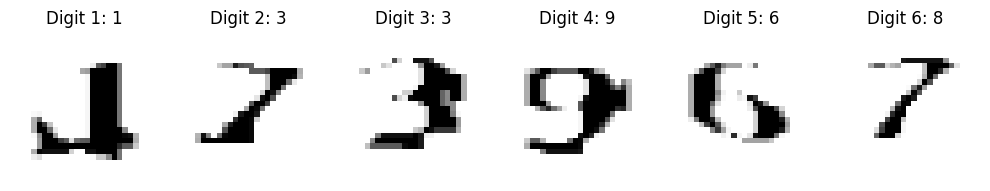

Recognized digits: 133968


In [79]:
import cv2
import numpy as np
import base64
from PIL import Image
from io import BytesIO
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

mnist_model = load_model("mnist_model.h5")

def segment_img(input_img):
    # Convert the PIL Image to a NumPy array
    image_array = np.array(input_img)
    
    # Image processing
    # Convert to grayscale
    img = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    
    # Adaptive thresholding
    th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, 2)

    # Otsu thresholding
    ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Otsu thresholding with Gaussian blur
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)

    dilation = cv2.dilate(th3, kernel, iterations=1)

    erosion = cv2.erode(dilation, kernel, iterations=1)

    kernel = np.ones((3,1), np.uint8)
    dilation = cv2.dilate(erosion, kernel, iterations=2)

    # Get individual letters
    x, y, w, h = 22, 10, 20, 38
    segments = []
    for i in range(6):
        # Save each character as a separate image
        digit = dilation[y:y + h, x:x + w]

        # Add a white border of 8 pixels
        digit = cv2.copyMakeBorder(digit, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[255, 255, 255])

        # Convert the digit to PIL Image
        digit_pil = Image.fromarray(digit)

        # Append the digit to the list of segments
        segments.append(digit_pil)

        x += w

    return segments




# Load the image file
image_file = "captcha_imgs/captcha_21.jpg"
with open(image_file, 'rb') as file:
    image_data = base64.b64encode(file.read()).decode('utf-8')

# Prepare the request payload
payload = {'image': image_data}

# Decode image from base64 and create an Image object
image_bytes = base64.b64decode(image_data)
image = Image.open(BytesIO(image_bytes))

# Segment the image
segmented_images = segment_img(image)

# Preprocess and display all segments using Matplotlib
preprocessed_segments = []
for i, segment in enumerate(segmented_images):
    # Preprocess the segment
    segment = np.array(segment)
    segment = cv2.resize(segment, (28, 28))
    segment = np.invert(segment)
    
    preprocessed_segments.append(segment)
    
# Predict the digits and print the images
recognized_text = ""
fig, axs = plt.subplots(1, len(preprocessed_segments), figsize=(10, 4))
for i, segment in enumerate(preprocessed_segments):
    # Reshape the segment for prediction
    segment = segment.reshape(1, 28, 28, 1)
    
    # Predict the digit using the pre-trained Keras MNIST model
    digit = mnist_model.predict(segment)
    
    # Append the recognized digit to the recognized text
    recognized_digit = str(np.argmax(digit))
    recognized_text += recognized_digit
    
    # Display the segment image with the recognized digit
    axs[i].imshow(segment.reshape(28, 28), plt.cm.binary)
    axs[i].axis('off')
    axs[i].set_title(f"Digit {i+1}: {recognized_digit}")
plt.tight_layout()
plt.show()

print("Recognized digits:", recognized_text)

